# Исследование данных интернет-магазина "Стримчик"

В нашем распоряжении данные интернет-магазина "Стримчик" о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно проанализировать данные и проверить несколько гипотез, чтобы грамотно спланировать рекламные кампании и сделать ставку на потенциально популярный продукт.


**Цель исследования:**


1. Узнать, одинаковы ли пользовательские рейтинги платформ Xbox One и PC.
2. Выяснить, правда ли, что пользовательские рейтинги жанров Action и Sports разные.


    **Ход исследования:**


   Данные об играх я получу из файла `/datasets/games.csv`. В данных могут быть ошибки, поэтому предварительно я займусь предобработкой данных, чтобы быть уверенной в том, что ошибки не повлияют на ход анализа. Если же я пойму, что ошибки критичны, я исправлю их там, где это будет возможно. Затем я приступлю к исследовательскому анализу, составлю портрет пользователя в каждом регионе и проверю гипотезы.
   В итоге, мое исследование пройдет в 6 этапов:

   - Загрузка данных
   - Предобработка данных
   - Исследовательский анализ данных
   - Портрет пользователя
   - Проверка гипотез
   - Общий вывод

## Загрузка данных

Для начала импортируем библиотеки *pandas, matplotlib, numpy, scipy.stats* и сохраним датасет, выведем на экран его первые 5 строк, чтобы посмотреть на содержимое, и изучим общую информацию датафрейма:

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
import numpy as np

In [8]:
from scipy import stats as st

In [9]:
import seaborn as sns

In [10]:
try:
    data = pd.read_csv('jupyter_projects/games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

In [11]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Пропусков много в оценках и рейтингах, а также небольшое количество пробелов в дате релиза. С типами данных тоже надо будет поработать.

## Предобработка данных

### Приведение к нижнему регистру

Для удобства приведем названия столбцов к нижнему регистру:

In [17]:
data.columns = data.columns.str.lower()

### Обработка типов данных

Приведем столбец `user_score` к типу `float`, потому что там все-таки стоят вещественные числа, а не объекты, но для начала узнаем, что кроме чисел и пропусков попало в этот столбец:

In [20]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Тут затесался `tbd` - аббревиатура **To be determined**. По сути, это то же, что и NaN, буквально отсутствие оценки, что могло возникнуть, например, если оценок собралось недостаточно для установки рейтинга или в целом игра не была оценена. Заменим и NaN, и tbd на заглушку - число `-1`, а затем преобразуем столбец к типу данных вещественные числа:

In [22]:
data['user_score'] = data['user_score'].replace('tbd', -1)
data['user_score'] = data['user_score'].fillna(-1)
data['user_score'] = data['user_score'].astype('float')

### Обработка пропусков

Начнем с пропусков в названиях и жанрах игр, посмотрим, вдруг жанры отсутствуют в тех же 2 строках, что и названия:

In [25]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,-1.0,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,-1.0,NaN


Это действительно так, причем обе игры с одной и той же платформы и выпущены в один год, какие-либо оценки у них отсутствуют, продаж у одной немало, а у другой почти 0. Удалим эти две строки, потому что информации в них крайне мало, без названия и жанра эти две игры бесполезны для анализа.

In [27]:
data = data.loc[~data['name'].isna()]

Пропуски в столбце `year_of_release` неприятны, они составляют 1.6% от данных, заполнить их получится лишь вручную, ориентируясь на даты релизов каждой игры на других платформах, поэтому оставим все, как есть. Пропусков не мало, поэтому удалив эти строки, можем потерять важные данные.

Осталось большое количество пропусков в столбцах с рейтингом и возрастным ограничением - `critic_score` и `rating`. Пропуски в этих столбцах могут обуславливаться тем же, чем и пропуски в `user_score`, которые мы ранее заполнили заглушками. Есть вероятность, что игры не получили оценку, потому что данных для выстраивания рейтинга недоставало, или же игры были выпущены очень давно, а кампания ESRB в тот момент еще не существовала. Все-таки в наших данных есть и игры 1980 годов. Заполним пропуски числом `-1`:

In [30]:
data['critic_score'] = data['critic_score'].fillna(-1)

In [31]:
data['rating'] = data['rating'].fillna(-1)

Проверим, все ли пропуски мы исправили:

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


### Обработка дубликатов

Для начала проверим, нет ли у нас дублирующихся строк:

In [36]:
data.duplicated().sum()

0

Теперь избавимся от неявных дубликатов - возможно, где-то есть строки с повторяющимися играми и платформами. Пока что в датафрейме 16713 строк, посмотрим, насколько изменится это число. Выведем строки-дубликаты, причем сначала аргументу `keep` присвоим значение `first`, а затем - `last`:

In [38]:
data[data.duplicated(subset=['name', 'platform'], keep='first')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


In [39]:
data[data.duplicated(subset=['name', 'platform'], keep='last')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T


*Madden NFL 13* - строки дублируются целиком, за исключением продаж. Удалим строку `16230`, в которой количество продаж слишком мало

*Sonic the Hedgehog* - в одной строке есть дата релиза, в другой нет, причем продаж там тоже чересчур мало, остальные данные одинаковы, удалим строку `4127`

*Need for Speed: Most Wanted на PC* - она вышла на PC в 2005 году, а вот на X360 в 2012, выходит, удаляем строки `1591` и `11715`

Значит, удаляем дубликаты, присваивая аргументу `keep` значение `last`. Итого, избавимся от 4 строк с неявными дубликатами.

In [41]:
data = data.drop_duplicates(subset=['name', 'platform'], keep='last')

### Столбец с суммарными продажами

Создадим столбец с суммарными продажами каждой игры:

In [44]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [45]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,-1,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,-1,31.38


## Исследовательский анализ данных

### Релизы в разные годы

Поменяем тип данных в столбце `year_of_release` на целочисленные значения, так график более читабельным: 

In [49]:
data['year_of_release'] = data.loc[~data['year_of_release'].isna(), 'year_of_release'].astype('Int64')

Посмотрим на количество релизов за каждый год в исследуемых данных:

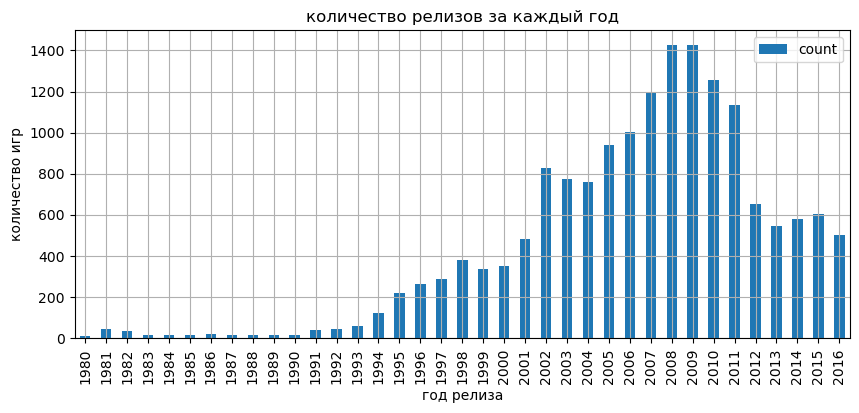

In [51]:
ax = data['year_of_release'].value_counts().sort_index().plot.bar(figsize=(10,4))
plt.xlabel('год релиза')
plt.ylabel('количество игр')
plt.grid()
plt.title('количество релизов за каждый год')
plt.legend();

**Вывод:** С 1980 по 1994 год количество выпущенных игр крайне мало - меньше 200 за каждый год, что не удивительно, ведь компьютерные игры в те времена только начали появляться. В 1995 году игры начали обретать популярность, в 2002 количество релизов сделало большой скачок, с 2004 плавно росло до 2008-2009 года, но после этого снизилось. Наверное из-за того, что развиваться стали телефоны и приложения для них, а к компьютерным играм интерес несколько приубавился.

### Количество продаж на платформах

Наша задача: узнать, за какое время появляются новые и исчезают старые платформы. Выведем топ-10 платформ по продажам:

In [55]:
data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).to_frame()

,total_sales
platform,
PS2,1255.77
X360,969.86
PS3,935.92
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Первые 6 платформ в списке - лидеры, продажи следующих меньше в два и более раз. Построим распределения по годам для `PS2`, `X360`, `PS3`, `Wii`, `DS` и `PS`:

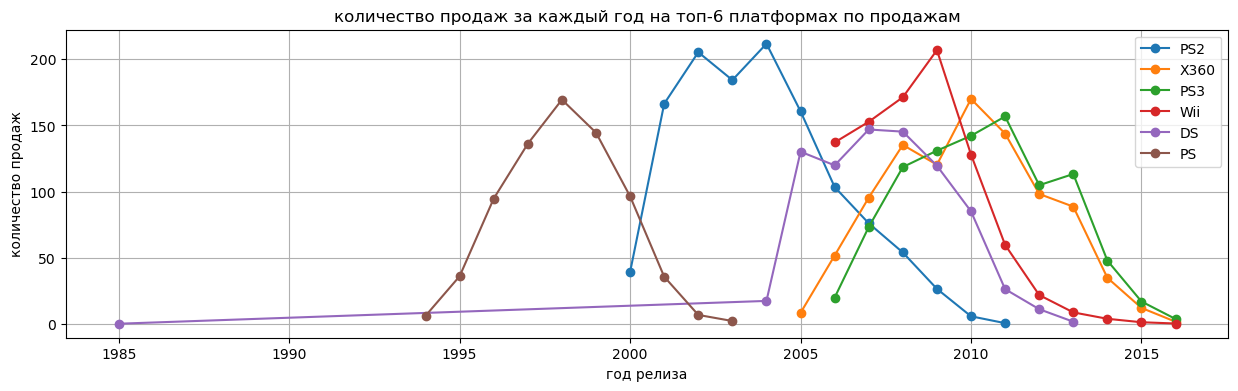

In [57]:
top_6 = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

ax = plt.gca()
legend = []

for platform in top_6:
    legend.append(platform)
    data_plot = data.query('platform == @platform')
    data_plot.groupby('year_of_release')['total_sales'].sum().plot(x='year_of_release', y='total_sales',
                                                                   style='o-', kind='line', ax=ax, figsize=(15,4))
    
ax.grid()
ax.set_xlabel('год релиза')
ax.set_ylabel('количество продаж')
ax.set_title('количество продаж за каждый год на топ-6 платформах по продажам')
ax.legend(legend);

*PS2* существовала с 2000 по 2011 год, то есть **12 лет**

*X360* - с 2005 по 2016, **12 лет**

*PS3* - с 2006 по 2016, **11 лет**

*Wii* - с 2006 по 2016, **11 лет**

*DS* - с 1985 по 2013, но после 1985 первые продажи начались лишь в 2004, то есть фактически платформа жила с 2004 по 2013, то есть **10 лет**

*PS* - с 1994 по 2003, **10 лет**

**Вывод:** В среднем, платформа живет 10 лет.

### Выбор актуального периода

Большинство топовых по продажам платформ живут с 2005 года, однако, как мы уже выяснили, платформа в среднем живет 10 лет, поэтому нет смысла строить прогнозы, включая в анализ те платформы, которые либо уже вымерли, либо на грани исчезновения. За актуальный период возьмем даты с 2014 по 2016 год.

In [62]:
actual_data = data.loc[data['year_of_release'] >= 2014]

In [63]:
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   Int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     1689 non-null   float64
 9   user_score       1689 non-null   float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 173.2+ KB


Пропуски в столбце с датой релиза отсутствуют в выбранных нами актуальных данных, выходит, что действительно пропущенные даты относятся к тем играм, которые даже не будут использованы в исследовании, так как уже не актуальны.

### Выбор потенциально прибыльных платформ

Выведем топ-10 платформ по продажам среди актуальных, но именно за 2016 год, потому что нам важно построить прогноз на 2017 год, а значит выбирать стоит те платформы, чьи продажи на конец 2016 года больше других:

In [67]:
actual_data.loc[
    data['year_of_release'] == 2016].groupby(
    'platform')['total_sales'].sum().sort_values(ascending=False).head(10).to_frame()

,total_sales
platform,
PS4,69.25
XOne,26.15
3DS,15.14
PC,5.25
WiiU,4.60
PSV,4.25
PS3,3.60
X360,1.52
Wii,0.18


Заметим, что здесь даже не 10 платформ, а всего 9, что означает, что к концу 2016 года живет всего 9 платформ.

Явный лидер - `PS4`, в топ-5 также войдут `XOne`,`3DS`, `PC` и `WiiU`. Осталось узнать, продажи на этих платформах падают или растут к 2016 году:

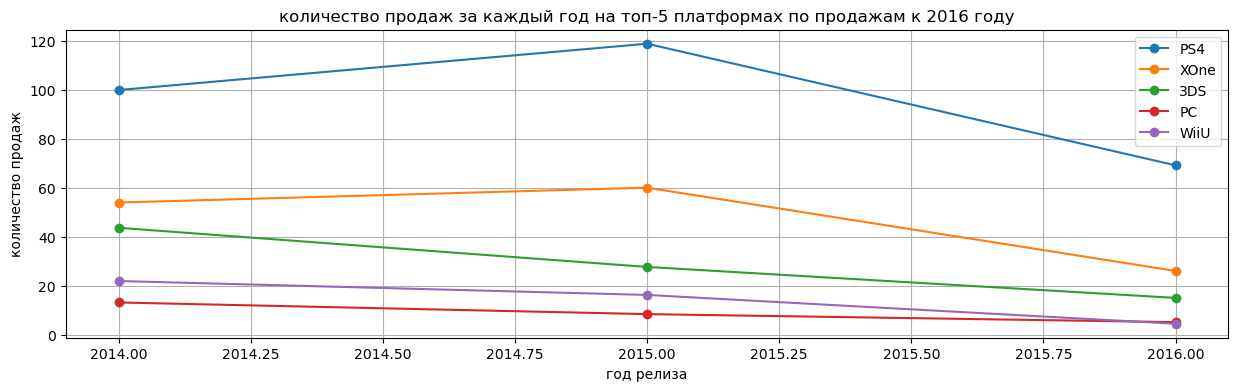

In [70]:
top_5 = ['PS4', 'XOne', '3DS', 'PC', 'WiiU']

ax = plt.gca()
legend = []

for platform in top_5:
    legend.append(platform)
    actual_data_plot = actual_data.query('platform == @platform')
    actual_data_plot.groupby('year_of_release')['total_sales'].sum().plot(x='year_of_release', y='total_sales',
                                                                   style='o-', kind='line', ax=ax, figsize=(15,4))
    
ax.grid()
ax.set_xlabel('год релиза')
ax.set_ylabel('количество продаж')
ax.set_title('количество продаж за каждый год на топ-5 платформах по продажам к 2016 году')
ax.legend(legend);

**Вывод:** Продажи на топ-5 платформах падают к концу 2016 года, а если это происходит с лидерами из актуального списка, то можно сделать вывод, что и в целом продажи падают. Хочется отметить, что продажи на `PC` самые стабильные среди нашего топа, продажи падают слабо и медленно.

### Глобальные продажи игр в разбивке по платформам

Построим графики "ящики с усами" для топ-9 платформ по продажам из актуальных данных. Затем построим еще одну визуализацию, поставив ограничение на ось `y`, чтобы отчетливее видеть медиану, верхнюю и нижнюю границы боксплотов:

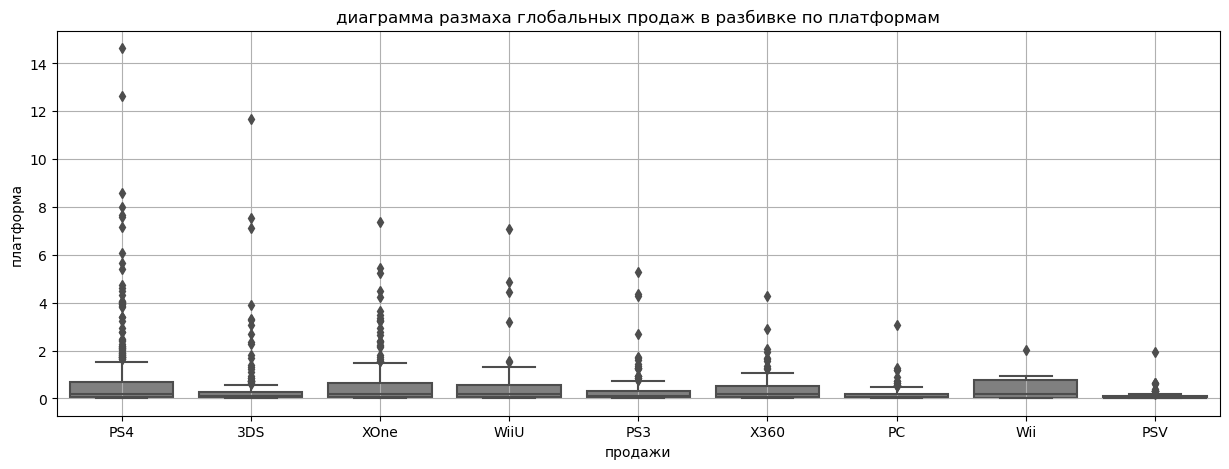

In [74]:
top_9 = actual_data.loc[
    actual_data['year_of_release'] == 2016].groupby(
    'platform')['total_sales'].sum().sort_values(ascending=False).reset_index()['platform'].tolist()

plt.figure(figsize=(15, 5))
sns.boxplot(y='total_sales', x='platform', data=actual_data.query('platform in @top_9'), color='grey')
plt.ylabel('платформа')
plt.xlabel('продажи')
plt.title('диаграмма размаха глобальных продаж в разбивке по платформам')
plt.grid();

Есть большие выбросы. Теперь посмотрим на графики поближе:

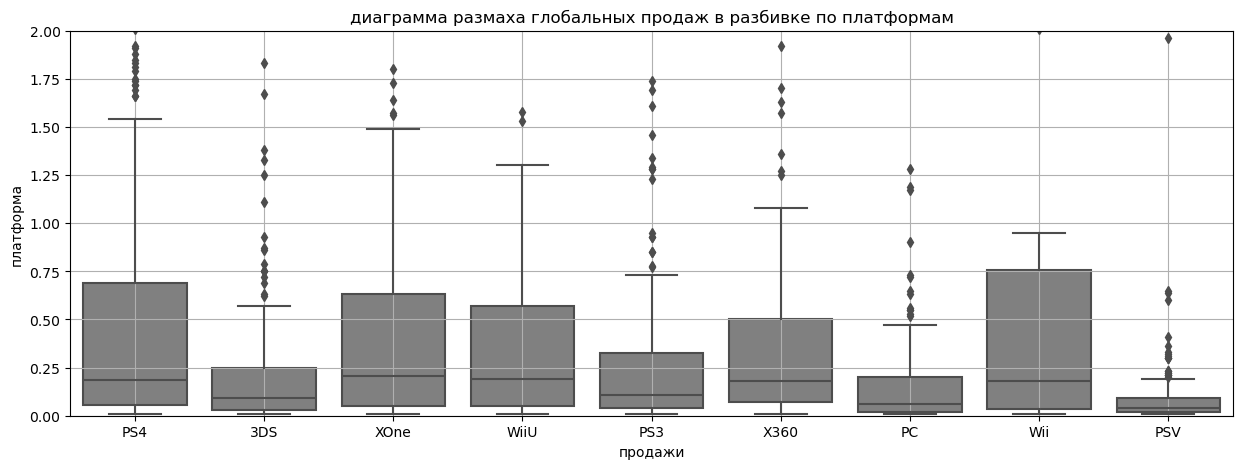

In [76]:
plt.figure(figsize=(15, 5))
sns.boxplot(y='total_sales', x='platform', data=actual_data.query('platform in @top_9'), color='grey')
plt.ylim(0, 2)
plt.ylabel('платформа')
plt.xlabel('продажи')
plt.title('диаграмма размаха глобальных продаж в разбивке по платформам')
plt.grid();

Очень низкие медианы на платформах `3DS`, `PSV`, `PS3` и `PC`- 0.1 миллион и меньше, в то время как на других платформах значения медианы варьируются от 0.2 до почти 0.3 миллионов. У двух из этих платформ (`PC` и `PSV`) верхние границы от 0.25 до 0.5 миллионов, у `PS3` 0.75, чуть меньше у `3DS`, что заметно ниже показателей остальных платформ

Верхние границы у платформ `XOne` и `PS4` около 1.5 миллионов, у остальных, за исключением тех четырех, что мы описали выше, верхняя граница лежит в промежутке от 1.1 до 1.3 миллионов.

На данном этапе исследования самыми перспективными платформами выглядят `XOne`, `PS4`, `PC` (так как это компьютер, и у него нет ограничения в 10 лет жизни), `WiiU` и `X360`.

### Влияние отзывов пользователей и критиков на продажи

Рассмотрим, как влияют отзывы на продажи на примере одной из самых популярных платформ, что по глобальному количеству продаж, что по продажам на конец 2016 года - `PS4`. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами:

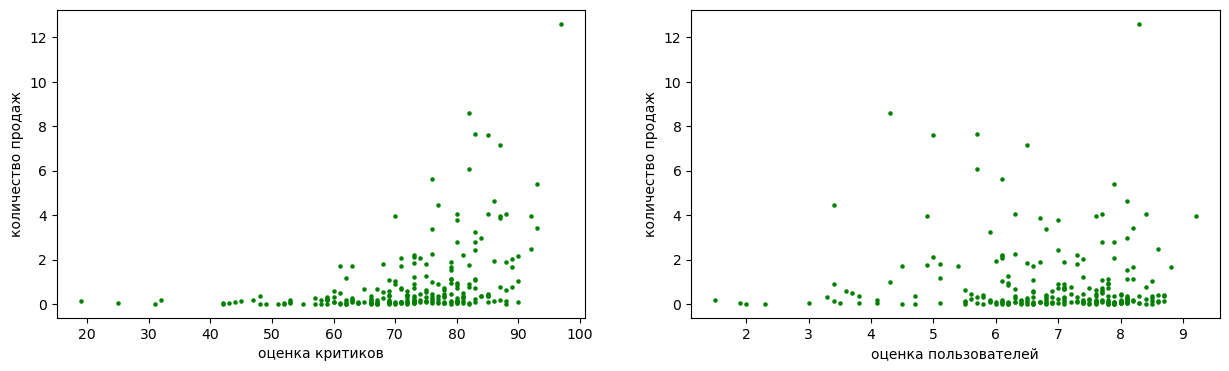

In [80]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 4)

ax[0].scatter(
    actual_data.query(
        'platform == "PS4" and critic_score >= 0')['critic_score'],
    actual_data.query(
        'platform == "PS4"  and critic_score >= 0')['total_sales'], s=5, c='g')
ax[0].set_xlabel('оценка критиков')
ax[0].set_ylabel('количество продаж')

ax[1].scatter(
    actual_data.query(
        'platform == "PS4" and user_score >= 0')['user_score'], 
    actual_data.query(
        'platform == "PS4" and user_score >= 0')['total_sales'], s=5, c='g')
ax[1].set_xlabel('оценка пользователей')
ax[1].set_ylabel('количество продаж');

**Вывод:** Чем выше оценка критиков, тем больше продаж, это ожидаемый результат, люди перед покупкой в первую очередь ориентируются на отзывы тех, кому можно доверять, в данном случае это оценка критиков. С оценкой пользователей дела обстоят похожим образом, однако наблюдается еще большее количество выбросов, все-таки на отзывы пользователей ориентируются реже, потому что оценка чересчур субъективна.

Посчитаем корреляцию между отзывами критиков/пользователей и продажами:

In [83]:
print('Корреляциия между отзывами критиков и продажами:' ,
      actual_data.query(
          'platform == "PS4" and critic_score >= 0')['critic_score'].corr(actual_data.query(
          'platform == "PS4" and critic_score >= 0')['total_sales']).round(2))

print('Корреляциия между отзывами пользователей и продажами:' ,
      actual_data.query(
          'platform == "PS4" and user_score >= 0')['user_score'].corr(actual_data.query(
          'platform == "PS4" and user_score >= 0')['total_sales']).round(2))

Корреляциия между отзывами критиков и продажами: 0.4
Корреляциия между отзывами пользователей и продажами: -0.04


**Вывод:** Выходит, что оценка пользователей вообще не влияет на продажи, а вот оценка критиков действительно весома. Однако причинно-следственная связь здесь не так однозначна, если игра достойная и качественная, то оценка критиков очевидно будет высокой, но игра и без этого имела бы хорошие продажи.

### Соотнесение выводов с продажами игр на других платформах

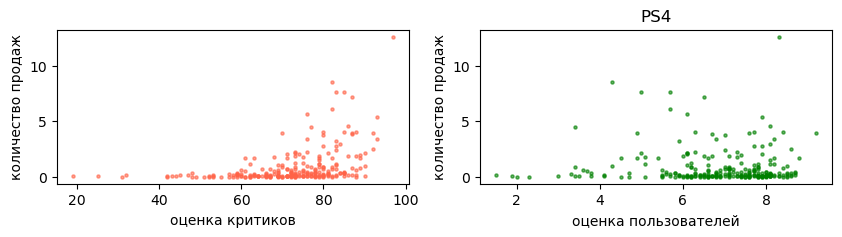

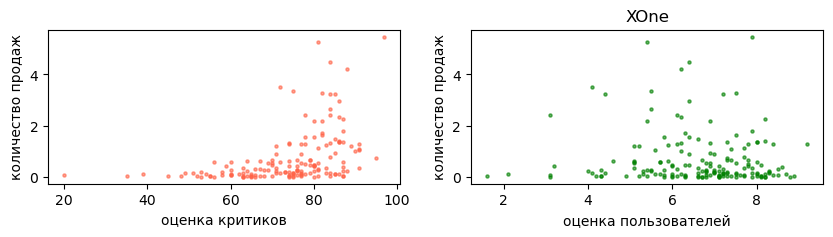

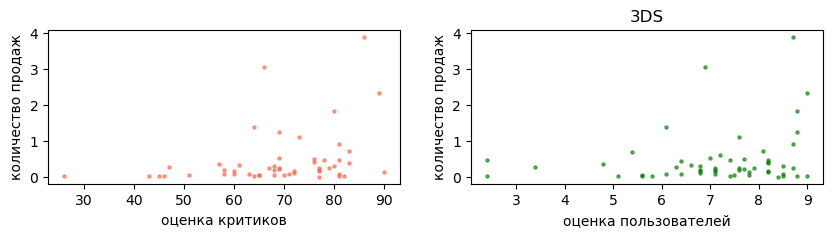

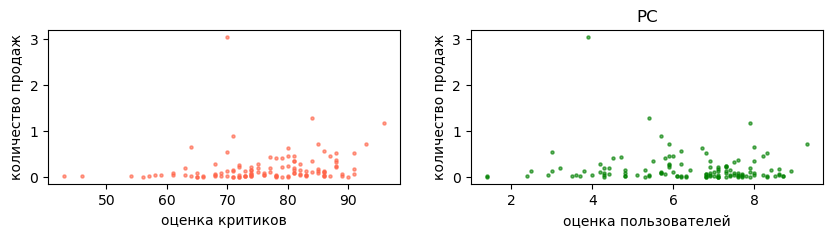

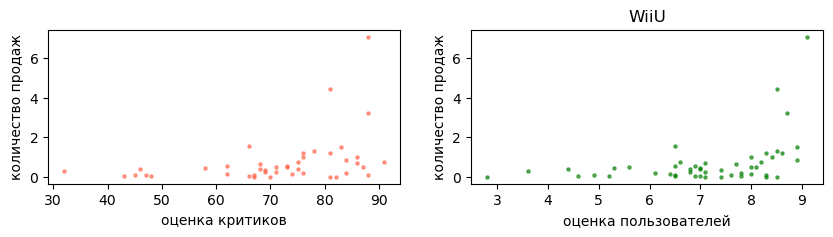

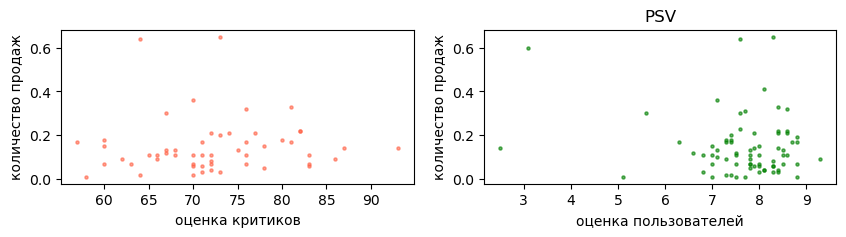

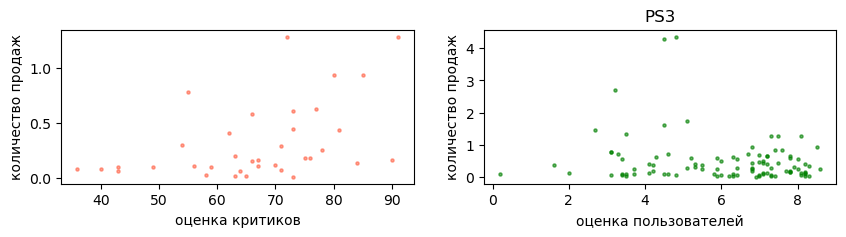

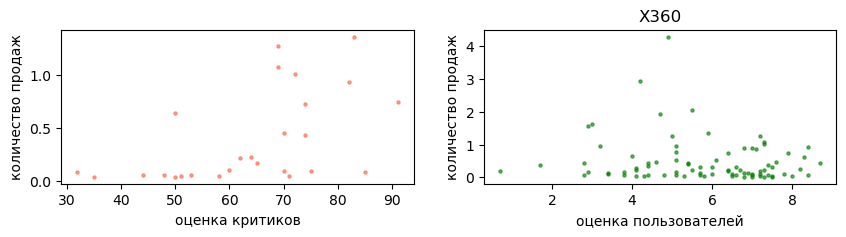

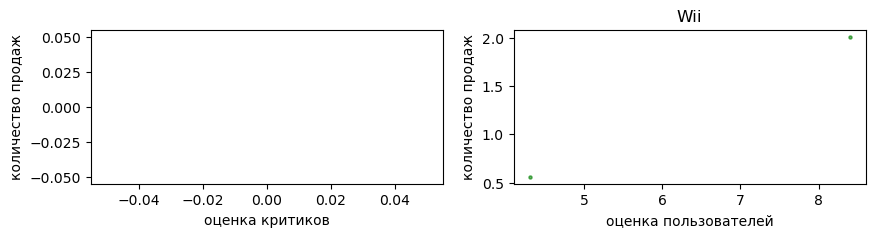

In [86]:
for platform in top_9:
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 2)
    plt.title(platform)

    ax[0].scatter(
        actual_data.query(
            'platform == @platform and critic_score >= 0')['critic_score'],
        actual_data.query(
            'platform == @platform  and critic_score >= 0')['total_sales'], s=5, c='tomato', alpha=0.6)
    ax[0].set_xlabel('оценка критиков')
    ax[0].set_ylabel('количество продаж')

    ax[1].scatter(
        actual_data.query(
            'platform == @platform and user_score >= 0')['user_score'], 
        actual_data.query(
            'platform == @platform and user_score >= 0')['total_sales'], s=5, c='g', alpha=0.6)
    ax[1].set_xlabel('оценка пользователей')
    ax[1].set_ylabel('количество продаж')

**Вывод:** Прямая зависимость продаж от оценки критиков видна на каждой из топ-9 платформ. А вот оценка пользователей в некоторых случаях будто бы влияет на продажи сильнее, чем это было на `PS4`. Проверим это, посчитав корреляцию. Но для `Wii` корреляцию считать не будем, судя по диаграмме значений там почти 0.

In [88]:
print('Корреляция между продажами и отзывами:')
print('')
for platform in top_9[0:8]:
    print(f'критиков на {platform}:' ,
          actual_data.query(
              'platform == @platform and critic_score >= 0')['critic_score'].corr(actual_data.query(
              'platform == @platform and critic_score >= 0')['total_sales']).round(2))
    
    print(f'пользователей на {platform}:' ,
          actual_data.query(
              'platform == @platform and user_score >= 0')['user_score'].corr(actual_data.query(
              'platform == @platform and user_score >= 0')['total_sales']).round(2))
    print('')

Корреляция между продажами и отзывами:

критиков на PS4: 0.4
пользователей на PS4: -0.04

критиков на XOne: 0.43
пользователей на XOne: -0.07

критиков на 3DS: 0.31
пользователей на 3DS: 0.22

критиков на PC: 0.17
пользователей на PC: -0.07

критиков на WiiU: 0.37
пользователей на WiiU: 0.41

критиков на PSV: 0.04
пользователей на PSV: -0.17

критиков на PS3: 0.45
пользователей на PS3: -0.17

критиков на X360: 0.53
пользователей на X360: -0.14



**Вывод:** Корреляция между отзывами пользователей и продажами везде почти одинаково мала по модулю, то есть связи между этими двумя параметрами, можно считать, нет. А вот от оценки критиков продажи все же зависят, правда не на всех платформах. Если посмотреть на значение корреляции на `PSV`, можно заметить, что оно крайне мало, но и данных по этой платформе не много - точек на диаграмме мало, примерно половина из них выбросы. Так как продаж на этой платформе немало, выходит, что отсутствуют оценки критиков. Но в конечном счете по большей части наш вывод в предыдущем пункте оправдан - продажи зависят от оценки критиков и не зависят от оценки пользователей.

### Распределение игр по жанрам

Посмотрим, какие жанры игр приносят наибольшую прибыль, а какие наоборот редко окупаются. Чтобы оценка была более менее объективной, следует посмотреть на медианное значение продаж каждого жанра, а также на среднее, так мы сможем выяснить, насколько стабильна окупаемость:

In [92]:
genre_data = actual_data.pivot_table(index='genre', aggfunc={'total_sales': ['mean', 'median']}).reset_index()
genre_data.columns = ['genre', 'mean_sales', 'median_sales']
genre_data['percentage'] = (genre_data['median_sales'] / genre_data['mean_sales']).round(2)
genre_data.sort_values(by='percentage', ascending=False)

,genre,mean_sales,median_sales,percentage
11,Strategy,0.107027,0.060,0.56
8,Shooter,1.335469,0.515,0.39
9,Simulation,0.298409,0.100,0.34
1,Adventure,0.094865,0.030,0.32
4,Platform,0.476053,0.140,0.29
5,Puzzle,0.157857,0.045,0.29
0,Action,0.322068,0.090,0.28
2,Fighting,0.470333,0.125,0.27
3,Misc,0.332301,0.090,0.27
10,Sports,0.680000,0.180,0.26


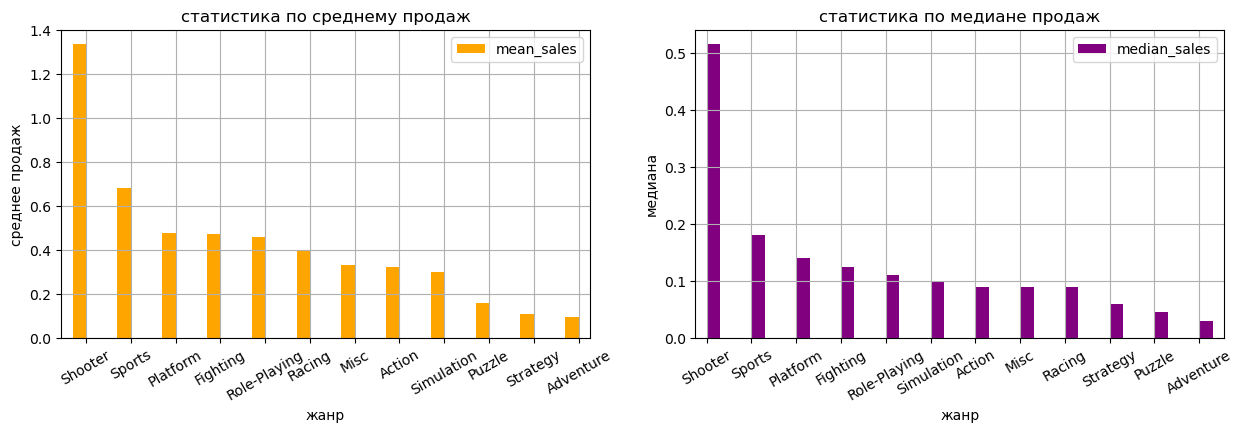

In [93]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 4)

genre_data.sort_values(by='mean_sales', ascending=False).plot(
    x='genre', y='mean_sales', kind='bar', ax=ax[0], position=1, color='orange', width=0.3, rot=30, 
    title='статистика по среднему продаж', xlabel='жанр', ylabel='среднее продаж', grid=True
)

genre_data.sort_values(by='median_sales', ascending=False).plot(
    x='genre', y='median_sales', kind='bar', ax=ax[1], position=0, color='purple', width=0.3, rot=30,
    title='статистика по медиане продаж', xlabel='жанр', ylabel='медиана', grid=True
);

**Вывод:** Жанры `Shooter`, `Sports`, `Platform`, `Fighting` и `Role-Playing` лидируют по обоим параметрам, причем именно в таком порядке. Но стоит обратить внимание на столбец `percentage` - в нем соотношение медианы и среднего по каждому жанру. Чем больше значение в этом столбце, тем стабильнее продаются игры того или иного жанра. И из нашего топа жанров лидирует `Shooter`, а вот **борьба**, **спортивные** и **ролевые** игры видимо выходят часто, но не каждый релиз оказывается успешным, лишь некоторые "выстреливают", о чем говорит маленькая по сравнению со средним значением медиана, однако суммы продаж все равно большие.

Cамыми стабильными являются игры, чьи продажи малы - `Strategy`, `Simmulation` и `Adventure`

Как итог, перспективными жанрами будем считать `Shooter`, `Platform`, `Sports`, `Fighting` и `Role-Playing`, но также в дальнейшем исследовании посмотрим на жанры `Action` и `Misc`, потому что их окупаемость довольно стабильна, среднее продаж не сильно меньше ролевых игр, хоть они и не вошли в наш топ-5.

## Портрет пользователя каждого региона

### Определение самых популярных платформ

Для наглядности отобразим это при помощи трех столбчатых графиков, расположенных в одном окне. Но для начала создадим сводные таблицы, содержащие информацию о доле продаж на каждой платформе относительно суммы продаж на всех этих платформах:

In [98]:
na_sales = actual_data.groupby('platform').agg({'na_sales': 'sum'})
na_sales['na_sales'] /= na_sales['na_sales'].sum()

eu_sales = actual_data.groupby('platform').agg({'eu_sales': 'sum'})
eu_sales['eu_sales'] /= eu_sales['eu_sales'].sum()

jp_sales = actual_data.groupby('platform').agg({'jp_sales': 'sum'})
jp_sales['jp_sales'] /= jp_sales['jp_sales'].sum()

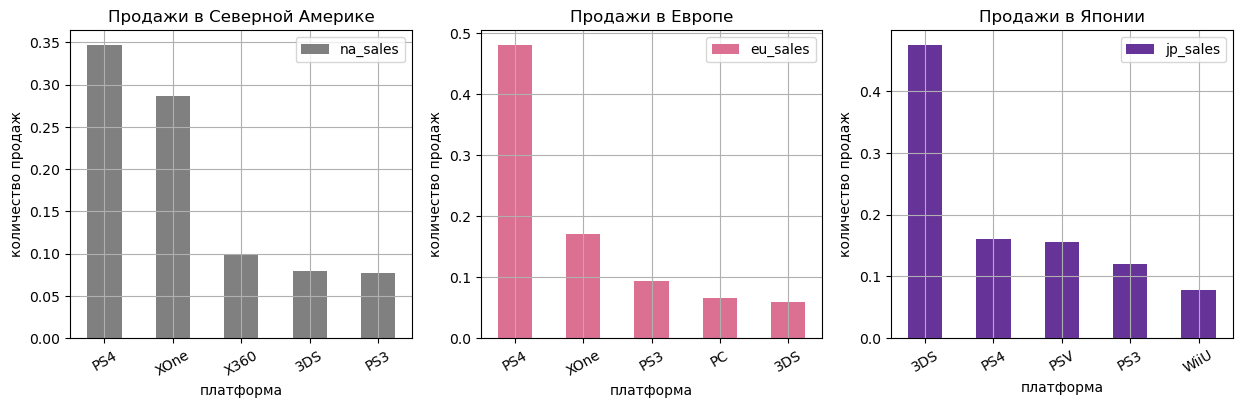

In [99]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)

na_sales.sort_values(
    by='na_sales', ascending=False).head().plot(
    kind='bar', ax=ax[0], color='grey', title='Продажи в Северной Америке', grid=True, 
    xlabel='платформа', ylabel='количество продаж', rot=30)

eu_sales.sort_values(
    by='eu_sales', ascending=False).head().plot(
    kind='bar', ax=ax[1], color='palevioletred', title='Продажи в Европе', grid=True, 
    xlabel='платформа', ylabel='количество продаж', rot=30)
    
jp_sales.sort_values(
    by='jp_sales', ascending=False).head().plot(
    kind='bar', ax=ax[2], color='rebeccapurple', title='Продажи в Японии', grid=True, 
    xlabel='платформа', ylabel='количество продаж', rot=30);

**Вывод:** `PS4` отхватывает самые большие доли по продажам в Европе и Америке и занимает второе место в Японии. На втором месте у NA и EU стоит `XOne`, но в Европе его доля более чем в 2 раза меньше первой по рейтингу платформы, тк PS4 составляет почти половину продаж. Платформа `PC`, которую мы ранее выделили как перспективную, входит в топ-5 лишь в Европе, в других регионах ее продажи сильно меньше продаж на других платформах.

В Японии самыми продаваемыми оказываются японские платформы, причем их `PS3` и `3DS` в сумме составляют по 15% продаж как в Европе, так и в Америке. `X360`, выпущенная в Америке, отхватывает там 10% продаж, в других регионах не пользуется таким спросом.

### Определение самых популярных жанров

In [102]:
na_sales = actual_data.groupby('genre').agg({'na_sales': 'sum'})
na_sales['na_sales'] /= na_sales['na_sales'].sum()

eu_sales = actual_data.groupby('genre').agg({'eu_sales': 'sum'})
eu_sales['eu_sales'] /= eu_sales['eu_sales'].sum()

jp_sales = actual_data.groupby('genre').agg({'jp_sales': 'sum'})
jp_sales['jp_sales'] /= jp_sales['jp_sales'].sum()

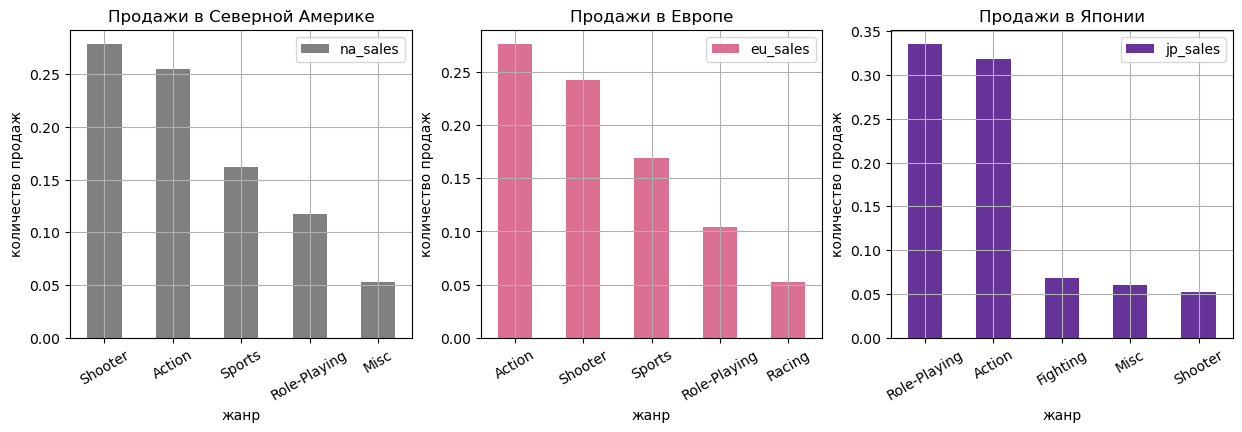

In [103]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)

na_sales.sort_values(
    by='na_sales', ascending=False).head().plot(
    kind='bar', ax=ax[0], color='grey', title='Продажи в Северной Америке', 
    grid=True, xlabel='жанр', ylabel='количество продаж', rot=30)

eu_sales.sort_values(
    by='eu_sales', ascending=False).head().plot(
    kind='bar', ax=ax[1], color='palevioletred', title='Продажи в Европе', 
    grid=True, xlabel='жанр', ylabel='количество продаж', rot=30)
    
jp_sales.sort_values(
    by='jp_sales', ascending=False).head().plot(
    kind='bar', ax=ax[2], color='rebeccapurple', title='Продажи в Японии', 
    grid=True, xlabel='жанр', ylabel='количество продаж', rot=30);

**Вывод:** В Америке и Европе лидируют одни и те же жанры, отличия лишь в последнем из топ-5 - в Америке `Misc`, в Европе `Racing`. Однако остальные жанры совпадают - `Action`, `Sports`, `Shooter` и `Role-Playing`. В Японии в топ тоже попали `Action`, `Misc` и `Shooter`, однако `Role-Playing` обгоняет по доле продаж экшн (хоть тот и не сильно отстает). 

Все это легко обуславливается интересами большинства жителей определенного региона, ни для кого не секрет, что ролевые игры как раз присущи Японцам, аналогично можно сказать и про остальное. Жанр экшн популярен везде и всегда, однако не является топ-1 в Японии, в Америке стрелялки тоже обогнали этот жанр, хоть и не на много. Спортивные игры обладают популярностью как минимум потому, что редко имеют высокие возрастные ограничения, а значит доступны не только взрослым, но и детям - доля их продаж в Америке и Европе около 17%. Стрелялки - любимая игра почти каждого человека мужского пола, однако в Японии эти игры не так распространены, продажи составляют всего 5%, предпологаю, что связано это со Второй Мировой, героями игр у японцев чаще являются какие-нибудь сказочные волшебники и тому подобное.

### Влияние рейтинга ESRB на продажи

Для начала следует расшифровать эти буквенные обозначения в рейтинге, иначе прочитать график будет сложно:

In [107]:
data['rating'].unique()

array(['E', -1, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [108]:
def categorize_esrb(rating):
    if rating == 'E' or rating == 'K-A':
        return 'для всех'
    elif rating == 'M':
        return '17+'
    elif rating == 'T':
        return '13+'
    elif rating == 'E10+':
        return '10+'
    elif rating == 'A0':
        return '18+'
    elif rating == 'EC':
        return '3+'
    elif rating == 'RP':
        return 'рейтинг ожидается'
    return 'не оценено'

In [109]:
data['esrb'] = data['rating'].apply(categorize_esrb)

In [110]:
actual_data = data.loc[data['year_of_release'] >= 2014]

Теперь построим графики:

In [112]:
na_sales = actual_data.groupby('esrb').agg({'na_sales': 'sum'})
na_sales['na_sales'] /= na_sales['na_sales'].sum()

eu_sales = actual_data.groupby('esrb').agg({'eu_sales': 'sum'})
eu_sales['eu_sales'] /= eu_sales['eu_sales'].sum()

jp_sales = actual_data.groupby('esrb').agg({'jp_sales': 'sum'})
jp_sales['jp_sales'] /= jp_sales['jp_sales'].sum()

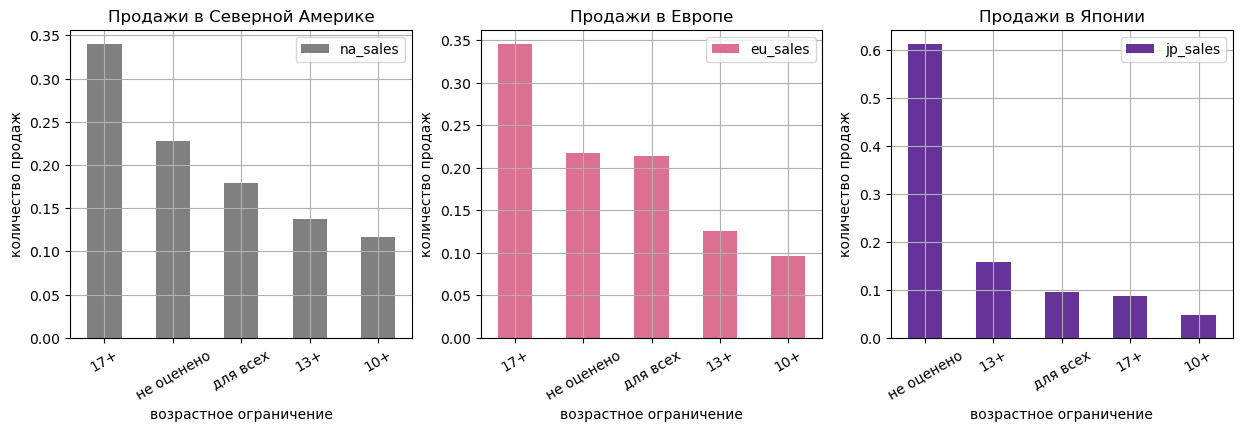

In [113]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)

na_sales.sort_values(
    by='na_sales', ascending=False).head().plot(
    kind='bar', ax=ax[0], color='grey', title='Продажи в Северной Америке', 
    grid=True, xlabel='возрастное ограничение', ylabel='количество продаж', rot=30)

eu_sales.sort_values(
    by='eu_sales', ascending=False).head().plot(
    kind='bar', ax=ax[1], color='palevioletred', title='Продажи в Европе', 
    grid=True, xlabel='возрастное ограничение', ylabel='количество продаж', rot=30)
    
jp_sales.sort_values(
    by='jp_sales', ascending=False).head().plot(
    kind='bar', ax=ax[2], color='rebeccapurple', title='Продажи в Японии', 
    grid=True, xlabel='возрастное ограничение', ylabel='количество продаж', rot=30);

**Вывод:** В Японии более 60% продаж составляют неоцененные игры, можно предположить, что связано это с тем, что в Японии большую часть продаж составляют ролевые игры, возможно многие из них оказываются популярными только в этом регионе, может даже производятся именно там, а учитывая также, что в основном японцы предпочитают платформы, созданные в их стране, есть вероятность, что их игры просто не попадают в оценивание американской компании ESRB, которая ставит возрастные ограничения на игры, произведенные в Америке.

В Америке и Европе продажи неоцененных игр составляют примерно по 23%, а вот лидерами продаж становятся игры 17+, в этих регионах заинтересованность в компьютерных играх присуща тинейджерам. И наоборот, в Японии игры 17+ это 9% продаж, зато детские - для детей 13+ - занимают долю в 17%, целевая аудитория в этом регионе отличается от двух других, но и игры, в которые они играют, совсем другие.

В Европе игры с рейтингом "для всех" также популярны, как и игры для тинейджеров, в Америке это 17% продаж, а в Японии 10%. Самыми не популярными оказываются игры для маленьких детей и тех, кому есть 10. 

## Проверка гипотез

### Одинаковы ли средние пользовательские рейтинги платформ Xbox One и PC?

Для начала сформулируем нулевую и альтернативную гипотезы:
- H0: Средний пользовательский рейтинг платформы **XOne** равен среднему пользовательскому рейтингу платформы **PC** 
- H1: Средний пользовательский рейтинг платформы **XOne** не равен среднему пользовательскому рейтингу платформы **PC** 

Так как две выборки независимы друг от друга, проверим гипотезу о равенстве среднего двух генеральных совокупностей с помощью t-критерия Стьюдента методом `st.ttest_ind()`. Пороговое значение `alpha` установим равное 0.05:

In [119]:
alpha = 0.05

xone_user_score = actual_data.query('platform == "XOne" and user_score >= 0')['user_score']
pc_user_score = actual_data.query('platform == "PC" and user_score >= 0')['user_score']
results = st.ttest_ind(xone_user_score, pc_user_score)

print(f'Среднее первой выборки: {np.mean(xone_user_score)}')
print(f'Среднее второй выборки: {np.mean(pc_user_score)}')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее первой выборки: 6.594545454545456
Среднее второй выборки: 6.298360655737705
p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


**Вывод:** p-значение чуть больше 10%, так как мы установили пороговое значение в 5%, то нулевую гипотезу отвергнуть не получается, однако p-значение не сильно большое, то есть вероятность получить наблюдаемый или более далекий от него результат не так велика. Однако, мы не отвергаем нулевую гипотезу и можем считать, что средние пользовательские рейтинги платформ `PC` и `Xbox One` одинаковы.

### Правда ли, что средние пользовательские рейтинги жанров `Action` и `Sports` разные

Для начала сформулируем нулевую и альтернативную гипотезы:
- H0: Средний пользовательский рейтинг жанра `Action` равен среднему пользовательскому рейтингу жанра `Sports`
- H1: Средний пользовательский рейтинг жанра `Action` не равен среднему пользовательскому рейтингу жанра `Sports` 

Аналогично предыдущему тесту, выборки в данном случае независимы, а значит снова воспользуемся методом `st.ttest_ind()`:

In [124]:
alpha = 0.05

action_user_score = actual_data.query('genre == "Action" and user_score >= 0')['user_score']
sports_user_score = actual_data.query('genre == "Sports" and user_score >= 0')['user_score']
results = st.ttest_ind(action_user_score, sports_user_score)

print(f'Среднее первой выборки: {np.mean(action_user_score)}')
print(f'Среднее второй выборки: {np.mean(sports_user_score)}')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее первой выборки: 6.760606060606061
Среднее второй выборки: 5.2251968503937
p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


**Вывод:** Вероятность получить наблюдаемый или еще более далекий от предпологаемого результат при условии, что нулевая гипотеза верна, очень мала, настолько, что почти равна 0, судя по p-значению. Следовательно, нулевую гипотезу мы отвергаем, а значит, средние пользовательские рейтинги жанров `Action` и `Sports` не одинаковы.

## Общий вывод

Мы провели исследование по данным интернет-магазина "Стримчик" и проверили несколько гипотез:

1. Средние пользовательские рейтинги платформ **Xbox One** и **PC** равны, эту гипотезу отвергнуть не удалось.
2.  Гипотезу о том, что средние пользовательские рейтинги жанров **Sports** и **Action** одинаковы, мы отвергли, рейтинги все же отличаются.


Интернет-магазину следует сделать акцент на играх жанров `Action`, `Sports` и `Shooter` - эти жанры популряны во всех регионах, для пользователей Японии актуальны ролевые игры. А также уклон следует делать на игры с возрастным ограничением `М` (17+), спрос на эти игры велик, не менее популярны игры для всех, однако для японских пользователей актуальны игры 13+. Самые интересующие пользователей и перспективные платформы - `PS4`, `PS3`, `3DS` и `XOne`. Стоит не забывать о `PC`, ее преимущество относительно других платформ - она живет не 10 лет. Среди пользователей Японии наиболее популярны японские платформы. 